# Transition Risk Analysis

## Objective
This script analyzes and projects Scope 1 and Scope 2 emissions for companies from 2025 to 2050, calculates carbon costs under different scenarios, evaluates abatement costs, and assesses tradeoffs between paying carbon prices and investing in abatement. The goal is to estimate future emissions paths and financial implications of carbon pricing for companies across various sectors and regions, using data from S&P Global.

## Key Functionalities
1. **Data Loading and Cleaning**:
   - Loads data from an Excel file containing emissions, reduction targets, abatement costs, and carbon prices.
   - Cleans data by standardizing column names, handling missing values, and correcting year formats.

2. **Emissions Projection**:
   - Projects Scope 1 and Scope 2 emissions to 2050 using absolute or intensity-based reduction targets.
   - Supports constant production or user-defined growth rates for intensity-based projections.

3. **Carbon Pricing Calculations**:
   - Computes carbon costs by multiplying projected emissions by scenario-specific carbon prices.
   - Includes a fallback to global carbon prices if region-specific prices are unavailable.
   - Aggregates abatement costs per company and calculates net savings from abatement vs. paying carbon costs.

4. **Visualization**:
   - Generates plots, including:
     - Stacked area chart of emissions by sector.
     - Heatmap of average carbon costs by scenario and year.
     - Waterfall chart comparing pay-only vs. abatement costs for a company.
     - Box plot of carbon cost distribution by country.
     - Scatter plot of abatement investment vs. net savings.
     - Carbon price projection curves for a sector and region.

## Data Requirements
- **Input File**: `S&P Global S1 Transition Risk Data.xlsx` with:
  - Table 1: Emissions data (uid, gics_sector, country, year, scope1_tonnes, scope2_tonnes, unit_production, production_volume).
  - Table 2: Reduction targets (uid, type_of_target, reduction_target, baseline, endline, etc.).
  - Table 3: Abatement costs (uid, abatement_cost_usd_year).
  - Table 4: Carbon prices (sector, region, year, scenario, carbon_price_usd_tco2e).
- **Dependencies**: `pandas`, `numpy`, `matplotlib`, `seaborn`, `openpyxl`.

## Usage
- Run the script directly (`transition_risk_analysis.py`) or in a Jupyter notebook.
- Ensure the Excel file is in the project directory.
- Install dependencies: `pip install pandas numpy matplotlib seaborn openpyxl`.

## Notes
- Missing values in emissions are imputed using median values by sector and size category.
- Carbon prices use region-specific values with a fallback to global prices.
- The script assumes a 0% production growth rate; adjust `production_growth_rate` in `project_emissions` if needed.

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
import numpy as np

In [ ]:


# # Set visualization style
# sns.set(style="whitegrid")

# # --- Data Loading ---
# file_path = "S&P Global S1 Transition Risk Data.xlsx"
# df_emissions = pd.read_excel(file_path, sheet_name="Table 1")
# df_targets = pd.read_excel(file_path, sheet_name="Table 2")
# df_abatement = pd.read_excel(file_path, sheet_name="Table 3")
# df_carbon_prices = pd.read_excel(file_path, sheet_name="Table 4")

# # --- Data Cleaning ---
# # Table 1: Emissions
# df_emissions.columns = ['uid', 'gics_sector', 'country', 'year', 'scope1_tonnes',
#                         'scope2_tonnes', 'unit_production', 'production_volume']
# df_emissions = df_emissions.drop_duplicates(subset='uid', keep='first')
# df_emissions['country'] = df_emissions['country'].fillna('Unknown').replace({'EUROPE': 'EU'})
# df_emissions['year'] = df_emissions['year'].replace({'2,025': 2025, '202five': 2025}).astype(int)
# # Step 1: Convert columns to numeric, coercing errors to NaN and clipping negative values
# df_emissions['scope1_tonnes'] = pd.to_numeric(df_emissions['scope1_tonnes'], errors='coerce').clip(lower=0)
# df_emissions['scope2_tonnes'] = pd.to_numeric(df_emissions['scope2_tonnes'], errors='coerce').clip(lower=0)

# # Step 2: Calculate sector means, ignoring NaN values
# # Step 1.5: Count missing values for scope1_tonnes and scope2_tonnes
# missing_scope1 = df_emissions['scope1_tonnes'].isna().sum()
# missing_scope2 = df_emissions['scope2_tonnes'].isna().sum()
# print(f"Missing values in scope1_tonnes: {missing_scope1}")
# print(f"Missing values in scope2_tonnes: {missing_scope2}")
# missing_by_sector = df_emissions.groupby('gics_sector')[['scope1_tonnes', 'scope2_tonnes']].apply(lambda x: x.isna().sum())
# print("Missing values by sector:\n", missing_by_sector)

# total_rows = len(df_emissions)
# print(f"Percentage missing in scope1_tonnes: {(missing_scope1 / total_rows) * 100:.2f}%")
# print(f"Percentage missing in scope2_tonnes: {(missing_scope2 / total_rows) * 100:.2f}%")

# # Step 1: Filter for "Materials" sector and define size categories
# materials_df = df_emissions[df_emissions['gics_sector'] == 'Materials'].copy()
# small_threshold = materials_df['production_volume'].quantile(0.33)
# large_threshold = materials_df['production_volume'].quantile(0.66)

# def categorize_size(volume):
#     if volume <= small_threshold:
#         return 'Small'
#     elif volume <= large_threshold:
#         return 'Medium'
#     else:
#         return 'Large'

# materials_df['size_category'] = materials_df['production_volume'].apply(categorize_size)

# # Step 2: Calculate median scope1_tonnes for each size category
# size_medians = materials_df.groupby('size_category')['scope1_tonnes'].median()

# # Step 3: Impute the missing value
# missing_row = materials_df[materials_df['scope1_tonnes'].isna()]
# missing_volume = missing_row['production_volume'].values[0]
# missing_size_category = categorize_size(missing_volume)
# imputed_value = size_medians[missing_size_category]
# materials_df.loc[materials_df['scope1_tonnes'].isna(), 'scope1_tonnes'] = imputed_value

# # Step 4: Update the original df_emissions with the imputed value
# df_emissions.loc[materials_df.index, 'scope1_tonnes'] = materials_df['scope1_tonnes']

# # Step 5: Validate
# print("Imputed value:", imputed_value)
# print("Updated Materials sector data in df_emissions:\n", df_emissions[df_emissions['gics_sector'] == 'Materials'])
# # Optional: Compare to similar companies
# same_category = materials_df[materials_df['size_category'] == missing_size_category]
# print(f"scope1_tonnes stats for {missing_size_category} companies:\n", same_category['scope1_tonnes'].describe())



/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_96109/93697988.py:23: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [271]:


# Set visualization style for consistent plotting
sns.set(style="whitegrid")

# Constants
FILE_PATH = "S&P Global S1 Transition Risk Data.xlsx"
YEAR_REPLACEMENTS = {'2,025': 2025, '202five': 2025}

#Objective: Load emissions data from an Excel file and clean it by standardizing column names,
# removing duplicates, correcting country and year formats, and ensuring emissions are numeric and non-negative.
# This prepares the data for imputation and downstream analysis.

def load_and_clean_emissions(file_path):
    """
    Load and clean emissions data from Excel.

    Args:
        file_path (str): Path to the Excel file.

    Returns:
        DataFrame: Cleaned emissions data.
    """
    # Load emissions data
    df_emissions = pd.read_excel(file_path, sheet_name="Table 1")
    
    # Standardize column names
    df_emissions.columns = ['uid', 'gics_sector', 'country', 'year', 'scope1_tonnes',
                            'scope2_tonnes', 'unit_production', 'production_volume']
    
    # Remove duplicates, clean country and year columns
    df_emissions = df_emissions.drop_duplicates(subset='uid', keep='first')
    df_emissions['country'] = df_emissions['country'].fillna('Unknown').replace({'EUROPE': 'EU'})
    df_emissions['year'] = df_emissions['year'].replace(YEAR_REPLACEMENTS).astype(int)
    
    # Convert emissions to numeric, handle invalid values, and ensure non-negative
    df_emissions[['scope1_tonnes', 'scope2_tonnes']] = df_emissions[['scope1_tonnes', 'scope2_tonnes']].apply(
        lambda x: pd.to_numeric(x, errors='coerce').clip(lower=0))
    
    return df_emissions

# Objective: Impute missing Scope 1 and Scope 2 emissions values for a specified sector (default: Materials)
# using median emissions from companies of similar size, based on production volume quantiles.
# This ensures a complete dataset for accurate emissions projections.

def impute_missing_emissions(df_emissions, sector='Materials'):
    """
    Impute missing emissions values for a specified sector using size-based median.

    Args:
        df_emissions (DataFrame): Emissions data with potential missing values.
        sector (str): Sector to impute (default: 'Materials').

    Returns:
        DataFrame: Emissions data with imputed values.
    """
    df = df_emissions.copy()
    sector_df = df[df['gics_sector'] == sector].copy()
    
    # Skip imputation if no missing values
    if not sector_df['scope1_tonnes'].isna().any() and not sector_df['scope2_tonnes'].isna().any():
        return df
    
    # Define size categories based on production volume
    small_threshold = sector_df['production_volume'].quantile(0.33)
    large_threshold = sector_df['production_volume'].quantile(0.66)
    
    def categorize_size(volume):
        """Categorize company size based on production volume."""
        if pd.isna(volume):
            return 'Medium'
        if volume <= small_threshold:
            return 'Small'
        elif volume <= large_threshold:
            return 'Medium'
        return 'Large'
    
    sector_df['size_category'] = sector_df['production_volume'].apply(categorize_size)
    
    # Calculate median emissions by size category
    size_medians = sector_df.groupby('size_category')[['scope1_tonnes', 'scope2_tonnes']].median()
    
    # Impute missing values
    for col in ['scope1_tonnes', 'scope2_tonnes']:
        missing_indices = sector_df[sector_df[col].isna()].index
        for idx in missing_indices:
            size_cat = sector_df.loc[idx, 'size_category']
            df.loc[idx, col] = size_medians.loc[size_cat, col]
    
    return df

def validate_emissions(df_emissions, sector='Materials'):
    """
    Validate emissions data by checking for missing values and summarizing results.

    Args:
        df_emissions (DataFrame): Emissions data to validate.
        sector (str): Sector to focus validation on (default: 'Materials').

    Returns:
        None: Prints validation results.
    """
    # Check missing values
    missing_scope1 = df_emissions['scope1_tonnes'].isna().sum()
    missing_scope2 = df_emissions['scope2_tonnes'].isna().sum()
    total_rows = len(df_emissions)
    print(f"Missing values in scope1_tonnes: {missing_scope1} ({missing_scope1 / total_rows * 100:.2f}%)")
    print(f"Missing values in scope2_tonnes: {missing_scope2} ({missing_scope2 / total_rows * 100:.2f}%)")
    
    # Missing values by sector
    missing_by_sector = df_emissions.groupby('gics_sector')[['scope1_tonnes', 'scope2_tonnes']].apply(
        lambda x: x.isna().sum())
    print("Missing values by sector:\n", missing_by_sector)
    
    # Validate imputed values for the specified sector
    sector_df = df_emissions[df_emissions['gics_sector'] == sector].copy()
    if not sector_df.empty:
        small_threshold = sector_df['production_volume'].quantile(0.33)
        large_threshold = sector_df['production_volume'].quantile(0.66)
        sector_df['size_category'] = sector_df['production_volume'].apply(
            lambda x: 'Small' if x <= small_threshold else 'Medium' if x <= large_threshold else 'Large')
        
        print(f"Updated {sector} sector data:\n", sector_df)
        for size_cat in sector_df['size_category'].unique():
            print(f"scope1_tonnes stats for {size_cat} companies in {sector}:\n",
                  sector_df[sector_df['size_category'] == size_cat]['scope1_tonnes'].describe())

# Objective: Orchestrate the loading, cleaning, imputation, and validation of emissions data.
# This serves as the entry point for the script, ensuring all steps are executed in order.

def main():
    """Main function to load, clean, impute, and validate emissions data."""
    # Suppress pandas FutureWarning for downcasting
    pd.set_option('future.no_silent_downcasting', True)
    
    # Load and clean emissions data
    df_emissions = load_and_clean_emissions(FILE_PATH)
    
    # Impute missing values for Materials sector
    df_emissions = impute_missing_emissions(df_emissions, sector='Materials')
    
    # Validate and print results
    validate_emissions(df_emissions, sector='Materials')

if __name__ == "__main__":
    main()

Missing values in scope1_tonnes: 0 (0.00%)
Missing values in scope2_tonnes: 0 (0.00%)
Missing values by sector:
                         scope1_tonnes  scope2_tonnes
gics_sector                                         
Consumer Discretionary              0              0
Energy                              0              0
Financials                          0              0
Healthcare                          0              0
IT                                  0              0
Industrials                         0              0
Materials                           0              0
Real Estate                         0              0
Utilities                           0              0
Updated Materials sector data:
      uid gics_sector    country  year  scope1_tonnes  scope2_tonnes  \
5   C006   Materials     Brazil  2025     24650000.0     13070000.0   
10  C011   Materials    Unknown  2025     24650000.0     13750000.0   
18  C019   Materials        USA  2025     15740000.0     10

In [241]:
# materials_df.head()

Missing values in scope1_tonnes: 1
Missing values in scope2_tonnes: 0
Missing values by sector:
                         scope1_tonnes  scope2_tonnes
gics_sector                                         
Consumer Discretionary              0              0
Energy                              0              0
Financials                          0              0
Healthcare                          0              0
IT                                  0              0
Industrials                         0              0
Materials                           1              0
Real Estate                         0              0
Utilities                           0              0
Percentage missing in scope1_tonnes: 2.00%
Percentage missing in scope2_tonnes: 0.00%


In [272]:
df_emissions.head()

,uid,gics_sector,country,year,scope1_tonnes,scope2_tonnes,unit_production,production_volume
0,C001,Real Estate,Global,2025,21510000.0,1070000.0,m2 building,46280000.0
1,C002,Energy,Brazil,2025,6570000.0,17510000.0,MWh,40950000.0
2,C003,Energy,EU,2025,19940000.0,7720000.0,MWh,69790000.0
3,C004,Consumer Discretionary,Unknown,2025,13340000.0,17140000.0,unit,98870000.0
4,C005,Financials,EU,2025,7470000.0,10710000.0,unit,68920000.0


In [273]:
df_targets.head()

,uid,type_of_target,reduction_target,comment,baseline_year,endline_year,reduction_value,reduction_type,reduction_unit
0,C001,Scope 2,0.547,NaN,2019,2050,0.547,absolute,%
1,C002,Scope 1,0.35 tCO2e/MWh,NaN,2020,2050,0.350,intensity,tCO2e/mwh
2,C003,Scope 2,0.256,NaN,2019,2050,0.256,absolute,%
3,C003,Scope 1,0.348,NaN,2018,2050,0.348,absolute,%
4,C004,Scope 2,0.188,NaN,2024,2050,0.188,absolute,%


Merge Emissions and Targets dataframe and clean and standardize

In [247]:

# Table 2: Targets
df_targets_raw = df_targets.copy()
df_targets.columns = df_targets.columns.str.strip().str.lower().str.replace(" ", "_")

# Enhanced year cleaning function
YEAR_WORDS = {
    'twenty-twenty': 2020,
    'twenty twenty': 2020,
    '2,024': 2024,
    '202four': 2024,
    'forty': 40  # For percentage, handled separately in reduction parsing
}

def clean_year(val):
    if pd.isna(val):
        return pd.NA
    s = str(val).strip().lower().replace(',', '')
    if s in YEAR_WORDS:
        return YEAR_WORDS[s]
    try:
        return int(s)
    except ValueError:
        return pd.NA

df_targets['baseline_year'] = df_targets['baseline'].apply(clean_year).astype('Int64')
df_targets['endline_year'] = df_targets['endline'].apply(clean_year).fillna(2050).astype('Int64')  # Assume 2050 if endline missing
df_targets.drop(columns=['baseline', 'endline'], inplace=True)

def split_reduction(val):
    if pd.isna(val):
        return pd.Series([np.nan, 'unknown', None])
    s = str(val).strip().lower()
    if s == 'forty%' or s == '40%':
        return pd.Series([0.40, 'absolute', '%'])
    m = re.match(r'([0-9]*\.?[0-9]+)\s*tco2e/?(.+)?', s)
    if m:
        num = float(m.group(1))
        unit = f"tCO2e/{m.group(2).strip()}" if m.group(2) else 'tCO2e'
        return pd.Series([num, 'intensity', unit])
    if s.endswith('%'):
        try:
            num = float(s.replace('%', '')) / 100
            return pd.Series([num, 'absolute', '%'])
        except ValueError:
            return pd.Series([np.nan, 'absolute', '%'])
    try:
        num = float(s)
        if num > 1:
            num = num / 100
        return pd.Series([num, 'absolute', '%'])
    except ValueError:
        return pd.Series([np.nan, 'unknown', None])

df_targets[['reduction_value', 'reduction_type', 'reduction_unit']] = df_targets['reduction_target'].apply(split_reduction)
df_targets_clean = df_targets[
    ['uid', 'type_of_target', 'reduction_target', 'reduction_value', 'reduction_type', 'reduction_unit', 'baseline_year', 'endline_year', 'comment']
].sort_values(['uid', 'type_of_target']).reset_index(drop=True)
df_targets_clean = df_targets_clean.dropna(subset=['baseline_year', 'reduction_value'])  # Drop if baseline or reduction missing

# Merge with emissions data
df_merged = df_targets_clean.merge(df_emissions, on="uid", how="left", indicator=True, suffixes=("", "_em"))
df_merged = df_merged.rename(columns={"_merge": "merge_status"})


/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_96109/1506939902.py:26: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
# filter for uid equal C011 
# df_filtered = df_merged[df_merged['uid'] == 'C011'].copy()

In [ ]:
# df_filtered.head()

,uid,type_of_target,reduction_target,reduction_value,reduction_type,reduction_unit,baseline_year,endline_year,comment,gics_sector,country,year,scope1_tonnes,scope2_tonnes,unit_production,production_volume,merge_status
10,C011,Scope 2,0.54,0.54,absolute,%,2019,2050,NaN,Materials,Unknown,2025.0,24650000.0,13750000.0,ton steel,19000000.0,both


In [ ]:
# # Table 3: Abatement
# df_abatement.columns = ['sector', 'region', 'technology', 'initial_investment_usd_million',
#                         'abatement_capacity_tco2e_year', 'abatement_cost_usd_tco2e_year']
# df_abatement['region'] = df_abatement['region'].replace({'Europa': 'EU'})

# # df_abatement['abatement_cost_usd_tco2e_year'] = pd.to_numeric(df_abatement['abatement_cost_usd_tco2e_year'], errors='coerce').fillna(df_abatement.groupby('sector')['abatement_cost_usd_tco2e_year'].transform('mean')).round(2)
# # 1. Convert to numeric (coerce non-numeric → NaN)
# df_abatement['abatement_cost_usd_tco2e_year'] = pd.to_numeric(
#     df_abatement['abatement_cost_usd_tco2e_year'],
#     errors='coerce'
# )
# # 2. Compute sector means on the numeric column
# sector_cost_means = df_abatement.groupby('sector')['abatement_cost_usd_tco2e_year'] \
#                                  .transform('mean')
# # 3. Fill NaNs with those means, then round
# df_abatement['abatement_cost_usd_tco2e_year'] = (
#     df_abatement['abatement_cost_usd_tco2e_year']
#       .fillna(sector_cost_means)
#       .round(2)
# )

# # Repeat for initial investment
# df_abatement['initial_investment_usd_million'] = pd.to_numeric(
#     df_abatement['initial_investment_usd_million'],
#     errors='coerce'
# )
# sector_inv_means = df_abatement.groupby('sector')['initial_investment_usd_million'] \
#                                 .transform('mean')
# df_abatement['initial_investment_usd_million'] = (
#     df_abatement['initial_investment_usd_million']
#       .fillna(sector_inv_means)
#       .round(2)
# )


# df_abatement['initial_investment_usd_million'] = df_abatement['initial_investment_usd_million'].fillna(
#     df_abatement.groupby('sector')['initial_investment_usd_million'].transform('mean')
# ).round(2)


# # Table 4: Carbon Prices
# df_carbon_prices.columns = ['sector', 'region', 'year', 'scenario', 'carbon_price_usd_tco2e']
# df_carbon_prices['region'] = df_carbon_prices['region'].replace({'Europa': 'EU'})
# df_carbon_prices['carbon_price_usd_tco2e'] = pd.to_numeric(df_carbon_prices['carbon_price_usd_tco2e'], errors='coerce').fillna(df_carbon_prices.groupby(['scenario', 'sector'])['carbon_price_usd_tco2e'].transform('mean')).round(2)

In [274]:
# --- Clean and Prepare Abatement Table ---
# Rename columns
df_abatement.columns = [
    'sector', 'region', 'technology',
    'initial_investment_usd_million',
    'abatement_capacity_tco2e_year',
    'abatement_cost_usd_tco2e_year'
]

# Standardize region names
df_abatement['region'] = df_abatement['region'].replace({'Europa': 'EU'})

# Convert numeric fields and impute missing values with sector means
for col in ['abatement_cost_usd_tco2e_year', 'initial_investment_usd_million']:
    df_abatement[col] = pd.to_numeric(df_abatement[col], errors='coerce')
    df_abatement[col] = df_abatement[col].fillna(
        df_abatement.groupby('sector')[col].transform('mean')
    ).round(2)

# --- Clean and Prepare Carbon Prices Table ---
# Rename columns
df_carbon_prices.columns = ['sector', 'region', 'year', 'scenario', 'carbon_price_usd_tco2e']

# Standardize region names
df_carbon_prices['region'] = df_carbon_prices['region'].replace({'Europa': 'EU'})

# Convert carbon prices and fill missing by scenario+sector group
df_carbon_prices['carbon_price_usd_tco2e'] = pd.to_numeric(
    df_carbon_prices['carbon_price_usd_tco2e'], errors='coerce'
)
df_carbon_prices['carbon_price_usd_tco2e'] = df_carbon_prices['carbon_price_usd_tco2e'].fillna(
    df_carbon_prices.groupby(['scenario', 'sector'])['carbon_price_usd_tco2e'].transform('mean')
).round(2)


In [ ]:
# df_merged.reduction_unit.unique()

array(['%', 'tCO2e/mwh', 'tCO2e/unit', 'tCO2e/m2 building'], dtype=object)

In [ ]:
# df_merged.head(2).tail(1)

,uid,type_of_target,reduction_target,reduction_value,reduction_type,reduction_unit,baseline_year,endline_year,comment,gics_sector,country,year,scope1_tonnes,scope2_tonnes,unit_production,production_volume,merge_status
1,C002,Scope 1,0.35 tCO2e/MWh,0.35,intensity,tCO2e/mwh,2020,2050,NaN,Energy,Brazil,2025.0,6570000.0,17510000.0,MWh,40950000.0,both


In [13]:
df_merged[df_merged['reduction_unit'] == 'tCO2e/m2 building'].iloc[0]

uid                                    C049
type_of_target                      Scope 1
reduction_target     0.42 tCO2e/m2 building
reduction_value                        0.42
reduction_type                    intensity
reduction_unit            tCO2e/m2 building
baseline_year                          2019
endline_year                           2050
comment                                 NaN
gics_sector                     Real Estate
country                              Global
year                                 2025.0
scope1_tonnes                    28100000.0
scope2_tonnes                     8550000.0
unit_production                 m2 building
production_volume                47220000.0
merge_status                           both
Name: 47, dtype: object

In [14]:
df_merged.iloc[10]

uid                        C011
type_of_target          Scope 2
reduction_target           0.54
reduction_value            0.54
reduction_type         absolute
reduction_unit                %
baseline_year              2019
endline_year               2050
comment                     NaN
gics_sector           Materials
country                 Unknown
year                     2025.0
scope1_tonnes        24650000.0
scope2_tonnes        13750000.0
unit_production       ton steel
production_volume    19000000.0
merge_status               both
Name: 10, dtype: object

In [ ]:
import pandas as pd
import numpy as np

def project_emissions(row, years=np.arange(2025, 2051), scenarios=None, interpolation_method='linear'):
    """
    Projects Scope 1 and Scope 2 emissions from 2025 to 2050 based on company-specific baseline data.
    Supports scenario-based production modeling and an S-curve scenario for emissions reduction.
    
    Parameters:
    - row: pd.Series with 'uid', 'baseline_scope1_tonnes', 'baseline_scope2_tonnes', 'baseline_production_volume', 
           'baseline_year', optionally 'scope1_tonnes' (2025), 'scope2_tonnes' (2025), 'production_volume' (2025), 
           'production_growth_rate', 'gics_sector', 'country', 'type_of_target'
    - years: np.ndarray, years to project (default: 2025-2050)
    - scenarios: dict, e.g., {'low': {'growth_rate': 0.0}, 'med': {'growth_rate': 0.01}, 's_curve': {'growth_rate': 0.02, 'interpolation': 's_curve'}}
                If None, uses row['production_growth_rate'] or 0.0 with default interpolation
    - interpolation_method: str, 'linear' (default), 'exponential', or 's_curve' if not overridden by scenario
    
    Returns:
    - pd.DataFrame with columns ['uid', 'gics_sector', 'country', 'type_of_target', 'year', 'scope1_tonnes', 'scope2_tonnes', 'scenario']
      or empty pd.DataFrame if baseline emissions or production volume are missing
    """
    # Extract basic information
    uid = row['uid']
    baseline_year = row['baseline_year']
    baseline_scope1 = row.get('baseline_scope1_tonnes')
    baseline_scope2 = row.get('baseline_scope2_tonnes')
    baseline_production = row.get('baseline_production_volume', 0)
    growth_rate_pre_2025 = row.get('production_growth_rate', 0.0)
    
    # Define targets (assumes global df_targets_clean exists)
    targets = df_targets_clean[df_targets_clean['uid'] == uid]
    
    # Determine 2025 emissions: use provided values or estimate from baseline
    if pd.notna(row.get('scope1_tonnes')) and pd.notna(row.get('scope2_tonnes')):
        scope1_2025 = row['scope1_tonnes']
        scope2_2025 = row['scope2_tonnes']
        production_volume = row.get('production_volume', baseline_production * (1 + growth_rate_pre_2025)**(2025 - baseline_year))
    else:
        if pd.isna(baseline_scope1) or pd.isna(baseline_scope2):
            print(f"Info: Skipping company {uid} due to missing baseline Scope 1 or Scope 2 emissions.")
            return pd.DataFrame()
        years_to_2025 = 2025 - baseline_year
        production_volume = baseline_production * (1 + growth_rate_pre_2025)**years_to_2025 if baseline_production > 0 else 0
        if any(targets['reduction_type'] == 'intensity'):
            if baseline_production == 0:
                print(f"Info: Skipping company {uid} due to missing baseline production volume for intensity target.")
                return pd.DataFrame()
            intensity_baseline = baseline_scope1 / baseline_production
            scope1_2025 = intensity_baseline * production_volume
            scope2_2025 = baseline_scope2
        else:
            scope1_2025 = baseline_scope1
            scope2_2025 = baseline_scope2
    
    # Set default scenario if none provided
    if scenarios is None:
        scenarios = {'default': {'growth_rate': row.get('production_growth_rate', 0.0), 'interpolation': interpolation_method}}
    
    emissions_path = []
    for scenario_name, scenario_params in scenarios.items():
        growth_rate = scenario_params.get('growth_rate', 0.0)
        scenario_interpolation = scenario_params.get('interpolation', interpolation_method)
        
        for year in years:
            scope1, scope2 = scope1_2025, scope2_2025
            production_volume_t = production_volume * (1 + growth_rate)**(year - 2025) if production_volume > 0 else 0
            
            # Apply emission reductions based on targets
            for _, target in targets.iterrows():
                endline_year = target['endline_year']
                reduction = target['reduction_value']
                target_type = target['type_of_target']
                reduction_type = target['reduction_type']
                n_years = endline_year - 2025
                
                if pd.isna(endline_year) or pd.isna(reduction) or endline_year <= 2025 or n_years <= 0:
                    continue
                
                # Calculate S-curve parameters if using s_curve interpolation
                if scenario_interpolation == 's_curve':
                    t_0 = 2025 + n_years / 2
                    k = 9.21 / n_years  # Ensures ~99% reduction by endline_year
                
                if target_type == 'Direct':
                    total_2025 = scope1_2025 + scope2_2025
                    if reduction_type == 'absolute':
                        target_em = total_2025 * (1 - reduction)
                        R = total_2025 - target_em
                        if scenario_interpolation == 'linear':
                            annual_red = R / n_years
                            total_reduced = max(0, total_2025 - (year - 2025) * annual_red if year <= endline_year else target_em)
                        elif scenario_interpolation == 'exponential':
                            r = (1 - reduction) ** (1 / n_years)
                            total_reduced = max(0, total_2025 * r ** (year - 2025) if year <= endline_year else target_em)
                        elif scenario_interpolation == 's_curve':
                            fraction = 1 / (1 + np.exp(-k * (year - t_0))) if year <= endline_year else 1
                            total_reduced = max(0, total_2025 - R * fraction)
                        scope1 = total_reduced * (scope1_2025 / total_2025) if total_2025 > 0 else scope1
                        scope2 = total_reduced * (scope2_2025 / total_2025) if total_2025 > 0 else scope2
                    else:  # intensity
                        I_2025 = total_2025 / production_volume if production_volume > 0 else 0
                        I_target = I_2025 * (1 - reduction)
                        if scenario_interpolation == 'linear':
                            fraction = min((year - 2025) / n_years, 1) if year <= endline_year else 1
                            I_t = I_2025 - fraction * (I_2025 - I_target)
                        elif scenario_interpolation == 'exponential':
                            r = (1 - reduction) ** (1 / n_years)
                            I_t = I_2025 * r ** (year - 2025) if year <= endline_year else I_target
                        elif scenario_interpolation == 's_curve':
                            fraction = 1 / (1 + np.exp(-k * (year - t_0))) if year <= endline_year else 1
                            I_t = I_2025 - fraction * (I_2025 - I_target)
                        total_reduced = I_t * production_volume_t
                        scope1 = total_reduced * (scope1_2025 / total_2025) if total_2025 > 0 else scope1
                        scope2 = total_reduced * (scope2_2025 / total_2025) if total_2025 > 0 else scope2
                else:
                    if 'Scope 1' in target_type:
                        emissions_2025 = scope1_2025
                    elif 'Scope 2' in target_type:
                        emissions_2025 = scope2_2025
                    else:
                        continue
                    if reduction_type == 'absolute':
                        target_em = emissions_2025 * (1 - reduction)
                        R = emissions_2025 - target_em
                        if scenario_interpolation == 'linear':
                            annual_red = R / n_years
                            reduction_applied = (year - 2025) * annual_red if year <= endline_year else R
                        elif scenario_interpolation == 'exponential':
                            r = (1 - reduction) ** (1 / n_years)
                            reduction_applied = emissions_2025 - (emissions_2025 * r ** (year - 2025)) if year <= endline_year else R
                        elif scenario_interpolation == 's_curve':
                            fraction = 1 / (1 + np.exp(-k * (year - t_0))) if year <= endline_year else 1
                            reduction_applied = R * fraction
                        if 'Scope 1' in target_type:
                            scope1 = max(0, emissions_2025 - reduction_applied)
                        if 'Scope 2' in target_type:
                            scope2 = max(0, emissions_2025 - reduction_applied)
                    else:  # intensity
                        I_2025 = emissions_2025 / production_volume if production_volume > 0 else 0
                        I_target = I_2025 * (1 - reduction)
                        if scenario_interpolation == 'linear':
                            fraction = min((year - 2025) / n_years, 1) if year <= endline_year else 1
                            I_t = I_2025 - fraction * (I_2025 - I_target)
                        elif scenario_interpolation == 'exponential':
                            r = (1 - reduction) ** (1 / n_years)
                            I_t = I_2025 * r ** (year - 2025) if year <= endline_year else I_target
                        elif scenario_interpolation == 's_curve':
                            fraction = 1 / (1 + np.exp(-k * (year - t_0))) if year <= endline_year else 1
                            I_t = I_2025 - fraction * (I_2025 - I_target)
                        emissions_t = I_t * production_volume_t
                        if 'Scope 1' in target_type:
                            scope1 = max(0, emissions_t)
                        if 'Scope 2' in target_type:
                            scope2 = max(0, emissions_t)
            
            emissions_path.append({
                'uid': uid,
                'gics_sector': row['gics_sector'],
                'country': row['country'],
                'type_of_target': row['type_of_target'],
                'year': year,
                'scope1_tonnes': round(scope1),
                'scope2_tonnes': round(scope2),
                'scenario': scenario_name
            })
    
    return pd.DataFrame(emissions_path)



In [17]:
df_merged.head()

,uid,type_of_target,reduction_target,reduction_value,reduction_type,reduction_unit,baseline_year,endline_year,comment,gics_sector,country,year,scope1_tonnes,scope2_tonnes,unit_production,production_volume,merge_status
0,C001,Scope 2,0.547,0.547,absolute,%,2019,2050,NaN,Real Estate,Global,2025.0,21510000.0,1070000.0,m2 building,46280000.0,both
1,C002,Scope 1,0.35 tCO2e/MWh,0.350,intensity,tCO2e/mwh,2020,2050,NaN,Energy,Brazil,2025.0,6570000.0,17510000.0,MWh,40950000.0,both
2,C003,Scope 1,0.348,0.348,absolute,%,2018,2050,NaN,Energy,EU,2025.0,19940000.0,7720000.0,MWh,69790000.0,both
3,C003,Scope 2,0.256,0.256,absolute,%,2019,2050,NaN,Energy,EU,2025.0,19940000.0,7720000.0,MWh,69790000.0,both
4,C004,Scope 2,0.188,0.188,absolute,%,2024,2050,NaN,Consumer Discretionary,Unknown,2025.0,13340000.0,17140000.0,unit,98870000.0,both


In [255]:
# Corrected scenarios dictionary
scenarios = {
    'low': {'growth_rate': 0.0, 'interpolation': 'linear'},
    'med': {'growth_rate': 0.01, 'interpolation': 'linear'},
    'high': {'growth_rate': 0.02, 'interpolation': 'linear'},
    's_curve_low': {'growth_rate': 0.0, 'interpolation': 's_curve'},
    's_curve_med': {'growth_rate': 0.01, 'interpolation': 's_curve'},
    's_curve_high': {'growth_rate': 0.02, 'interpolation': 's_curve'}
}

# Run the projection
# emissions_paths = project_emissions(df_merged, scenarios=scenarios)
# Apply the function and concatenate results
emissions_paths_list = df_merged.apply(
    lambda row: project_emissions(row, scenarios=scenarios), axis=1
).tolist()
emissions_paths = pd.concat(emissions_paths_list, ignore_index=True)

# Define mappings
growth_rate_mapping = {
    'low': 0.0,
    'med': 0.01,
    'high': 0.02,
    's_curve_low': 0.0,
    's_curve_med': 0.01,
    's_curve_high': 0.02
}

interpolation_mapping = {
    'low': 'linear',
    'med': 'linear',
    'high': 'linear',
    's_curve_low': 's_curve',
    's_curve_med': 's_curve',
    's_curve_high': 's_curve'
}

# Add columns
emissions_paths['growth_rate'] = emissions_paths['scenario'].map(growth_rate_mapping)
emissions_paths['interpolation_method'] = emissions_paths['scenario'].map(interpolation_mapping)



Info: Skipping company C999 due to missing baseline Scope 1 or Scope 2 emissions.


In [256]:
#export the emissions_paths DataFrame to a CSV file
emissions_paths.to_csv("emissions_paths.csv", index=False)
# export df_merged to a CSV file
df_merged.to_csv("df_merged.csv", index=False)
# export df_emissions to a CSV file
df_emissions.to_csv("df_emissions.csv", index=False)
# export df_targets_clean to a CSV file
df_targets_clean.to_csv("df_targets_clean.csv", index=False)
# export df_abatement to a CSV file
df_abatement.to_csv("df_abatement.csv", index=False)
# export df_carbon_prices to a CSV file
df_carbon_prices.to_csv("df_carbon_prices.csv", index=False)

In [65]:
df_targets.head()

,uid,type_of_target,reduction_target,comment,baseline_year,endline_year,reduction_value,reduction_type,reduction_unit
0,C001,Scope 2,0.547,NaN,2019,2050,0.547,absolute,%
1,C002,Scope 1,0.35 tCO2e/MWh,NaN,2020,2050,0.350,intensity,tCO2e/mwh
2,C003,Scope 2,0.256,NaN,2019,2050,0.256,absolute,%
3,C003,Scope 1,0.348,NaN,2018,2050,0.348,absolute,%
4,C004,Scope 2,0.188,NaN,2024,2050,0.188,absolute,%


In [257]:
# Handle all relevant target types properly
def get_targeted_emissions(row):
    if row['type_of_target'] == 'Scope 1':
        return row['scope1_tonnes']
    elif row['type_of_target'] == 'Scope 2':
        return row['scope2_tonnes']
    elif row['type_of_target'] in ['Direct', 'Scope 2 and other']:
        return row['scope1_tonnes'] + row['scope2_tonnes']
    else:
        return np.nan

emissions_paths['targeted_emissions'] = emissions_paths.apply(get_targeted_emissions, axis=1)

# Keep only valid rows
df_filtered = emissions_paths[~emissions_paths['targeted_emissions'].isna()].copy()


/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_96109/2106248026.py:32: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/opt/anaconda3/envs/sp_work/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



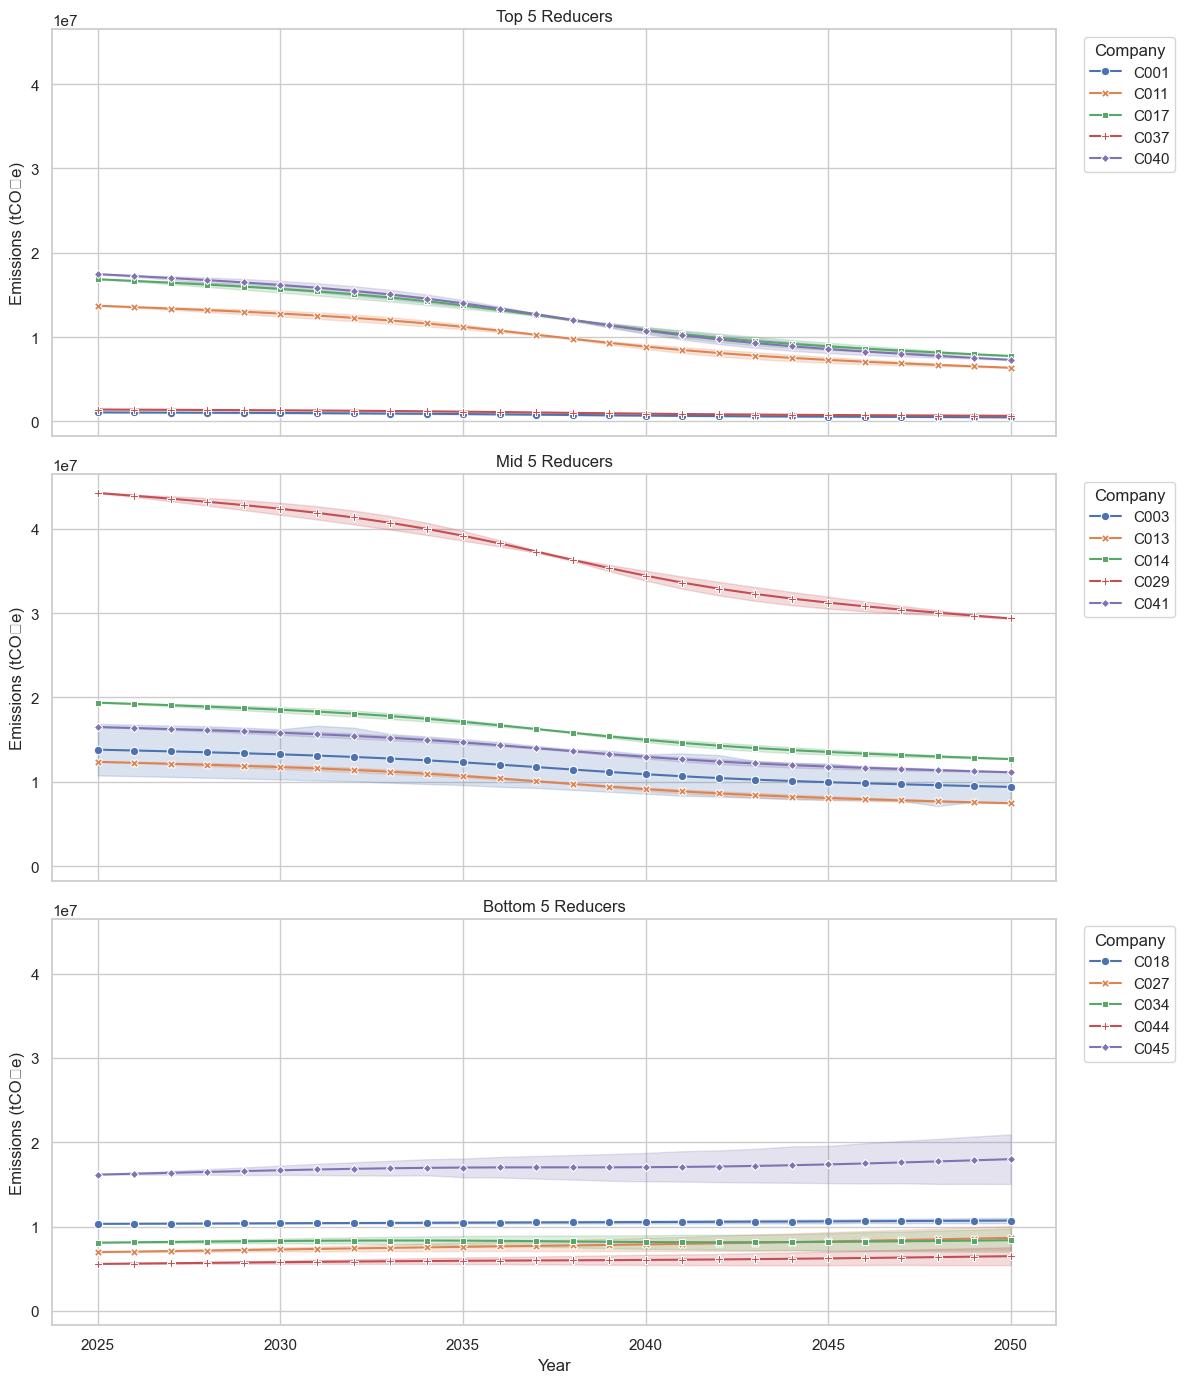

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare buckets
sorted_uids = matrix['pct_reduction'].sort_values()
buckets = {
    'Top 5': sorted_uids.index[-5:],
    'Mid 5': sorted_uids.index[25:30],
    'Bottom 5': sorted_uids.index[:5],
}

# 2. Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True, sharey=True)

for ax, (label, uids) in zip(axes, buckets.items()):
    subset = df_filtered[df_filtered['uid'].isin(uids)]
    sns.lineplot(
        data=subset,
        x='year',
        y='targeted_emissions',
        hue='uid',
        style='uid',
        markers=True,
        dashes=False,
        ax=ax
    )
    ax.set_title(f'{label} Reducers')
    ax.set_ylabel('Emissions (tCO₂e)')
    ax.legend(title='Company', bbox_to_anchor=(1.02, 1), loc='upper left')

axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()


In [76]:
emissions_paths.interpolation_method.unique()

array(['linear', 's_curve'], dtype=object)

In [259]:
import pandas as pd

# Pivot out 2025 & 2050, compute percent reduction **per scope**
df_pr = (
    emissions_paths
    .loc[emissions_paths['year'].isin([2025, 2050]), 
         ['uid','gics_sector','country','scope1_tonnes','scope2_tonnes','year']]
    .pivot_table(
        index=['uid','gics_sector','country'],
        columns='year',
        values=['scope1_tonnes','scope2_tonnes']
    )
)

# Flatten MultiIndex columns
df_pr.columns = [f"{scope}_{yr}" for scope, yr in df_pr.columns]
df_pr = df_pr.dropna()

# Compute reductions
df_pr['pct_red_1'] = (df_pr['scope1_tonnes_2025'] - df_pr['scope1_tonnes_2050']) / df_pr['scope1_tonnes_2025'] * 100
df_pr['pct_red_2'] = (df_pr['scope2_tonnes_2025'] - df_pr['scope2_tonnes_2050']) / df_pr['scope2_tonnes_2025'] * 100

# Reset for plotting
df_pr = df_pr.reset_index()


In [275]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # A1. Mean % Reduction by Country: Scope 1
# plt.figure(figsize=(10,4))
# sns.barplot(
#     data=df_pr, x='country', y='pct_red_1',
#     estimator='mean', ci=None, order=df_pr.groupby('country')['pct_red_1'].mean().sort_values().index
# )
# plt.xticks(rotation=45, ha='right')
# plt.title('Mean Scope 1 % Reduction by Country (2025→2050)')
# plt.ylabel('% Reduction')
# plt.xlabel('')
# plt.tight_layout()
# plt.show()

# # A2. Mean % Reduction by Country: Scope 2
# plt.figure(figsize=(10,4))
# sns.barplot(
#     data=df_pr, x='country', y='pct_red_2',
#     estimator='mean', ci=None, order=df_pr.groupby('country')['pct_red_2'].mean().sort_values().index
# )
# plt.xticks(rotation=45, ha='right')
# plt.title('Mean Scope 2 % Reduction by Country (2025→2050)')
# plt.ylabel('% Reduction')
# plt.xlabel('')
# plt.tight_layout()
# plt.show()


/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_96109/1954284895.py:17: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/opt/anaconda3/envs/sp_work/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



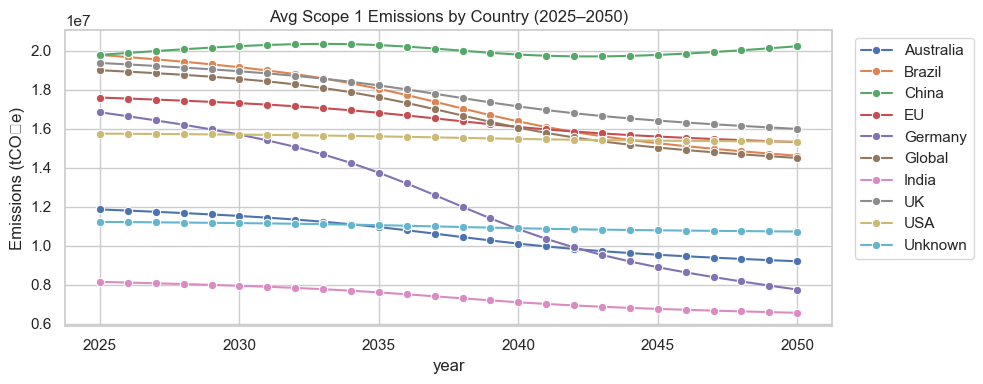

/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_96109/1954284895.py:29: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/opt/anaconda3/envs/sp_work/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



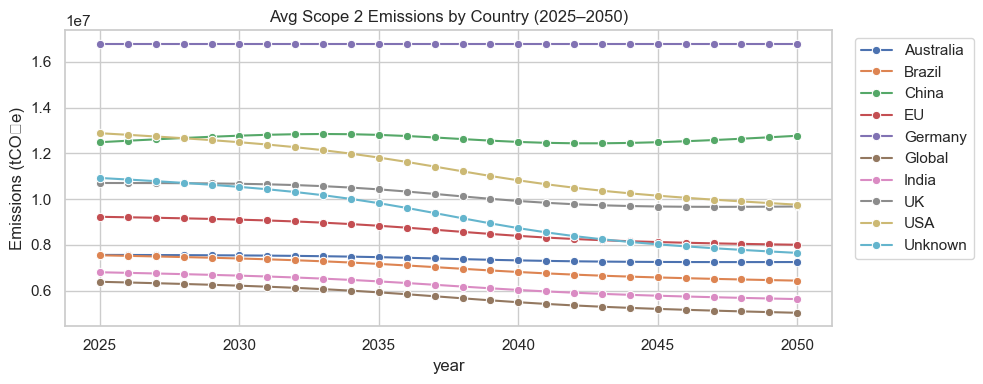

In [261]:
country_trends = (
    emissions_paths
    .groupby(['country','year'])[['scope1_tonnes','scope2_tonnes']]
    .mean()
    .reset_index()
)

# B1. Scope 1 Trajectories
plt.figure(figsize=(10,4))
sns.lineplot(
    data=country_trends, x='year', y='scope1_tonnes',
    hue='country', marker='o'
)
plt.title('Avg Scope 1 Emissions by Country (2025–2050)')
plt.ylabel('Emissions (tCO₂e)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

# B2. Scope 2 Trajectories
plt.figure(figsize=(10,4))
sns.lineplot(
    data=country_trends, x='year', y='scope2_tonnes',
    hue='country', marker='o'
)
plt.title('Avg Scope 2 Emissions by Country (2025–2050)')
plt.ylabel('Emissions (tCO₂e)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()



In [66]:
emissions_paths.type_of_target.unique()

array(['Scope 2', 'Scope 1', 'Scope 3', 'Direct', 'Scope 2 and other'],
      dtype=object)

In [ ]:
# data.head()

,uid,gics_sector,country,type_of_target_x,year,scope1_tonnes,scope2_tonnes,scenario,growth_rate,interpolation_method,type_of_target_y,reduction_target,comment,baseline_year,endline_year,reduction_value,reduction_type,reduction_unit,total_emissions
0,C001,Real Estate,Global,Scope 2,2025,21510000,1070000,low,0.0,linear,Scope 2,0.547,NaN,2019,2050,0.547,absolute,%,22580000
1,C001,Real Estate,Global,Scope 2,2026,21510000,1046588,low,0.0,linear,Scope 2,0.547,NaN,2019,2050,0.547,absolute,%,22556588
2,C001,Real Estate,Global,Scope 2,2027,21510000,1023177,low,0.0,linear,Scope 2,0.547,NaN,2019,2050,0.547,absolute,%,22533177
3,C001,Real Estate,Global,Scope 2,2028,21510000,999765,low,0.0,linear,Scope 2,0.547,NaN,2019,2050,0.547,absolute,%,22509765
4,C001,Real Estate,Global,Scope 2,2029,21510000,976354,low,0.0,linear,Scope 2,0.547,NaN,2019,2050,0.547,absolute,%,22486354


In [59]:
emissions_paths.head()

,uid,gics_sector,country,type_of_target,year,scope1_tonnes,scope2_tonnes,scenario,growth_rate,interpolation_method
0,C001,Real Estate,Global,Scope 2,2025,21510000,1070000,low,0.0,linear
1,C001,Real Estate,Global,Scope 2,2026,21510000,1046588,low,0.0,linear
2,C001,Real Estate,Global,Scope 2,2027,21510000,1023177,low,0.0,linear
3,C001,Real Estate,Global,Scope 2,2028,21510000,999765,low,0.0,linear
4,C001,Real Estate,Global,Scope 2,2029,21510000,976354,low,0.0,linear


In [61]:
emissions_paths.uid.unique()

array(['C001', 'C002', 'C003', 'C004', 'C005', 'C006', 'C008', 'C009',
       'C010', 'C011', 'C012', 'C013', 'C014', 'C015', 'C016', 'C017',
       'C018', 'C019', 'C020', 'C021', 'C022', 'C023', 'C024', 'C025',
       'C027', 'C028', 'C029', 'C030', 'C031', 'C032', 'C033', 'C034',
       'C035', 'C036', 'C037', 'C038', 'C039', 'C040', 'C041', 'C042',
       'C043', 'C044', 'C045', 'C046', 'C047', 'C048', 'C049', 'C050'],
      dtype=object)

In [28]:
df_merged.to_csv("emissions_targets.csv", index=False)

Estimate Carbon pricing

In [ ]:
# Check for negative or zero values in the 'carbon_price_usd_tco2e' column
negative_prices = df_carbon_prices['carbon_price_usd_tco2e'] <= 0
print(negative_prices)  # Returns a boolean Series
print(negative_prices.any())  # Returns True if any value is <= 0
print(df_carbon_prices[negative_prices])

In [279]:
df_carbon_prices.head(5)

,sector,region,year,scenario,carbon_price_usd_tco2e
0,Energy,USA,2025,Low Risk,58.07
1,Energy,USA,2027,Low Risk,57.92
2,Energy,USA,2030,Low Risk,59.77
3,Energy,USA,2025,Medium Risk,55.26
4,Energy,USA,2027,Medium Risk,65.63


In [280]:
df_carbon_prices.tail()

,sector,region,year,scenario,carbon_price_usd_tco2e
220,Consumer Discretionary,Global,2027,Medium Risk,30.95
221,Consumer Discretionary,Global,2030,Medium Risk,37.49
222,Consumer Discretionary,Global,2025,High Risk,26.28
223,Consumer Discretionary,Global,2027,High Risk,39.87
224,Consumer Discretionary,Global,2030,High Risk,49.70


In [277]:
# ngf5_eu_carbon_prices

In [140]:
ngf5_global_carbon_prices = pd.read_csv("/Users/tarunluthra/Documents/SPglobal/ngfs_global_snapshot_1750868451.csv")

In [141]:
ngf5_global_carbon_prices.head()

,Model,Scenario,Region,Variable,Unit,2020,2025,2030,2035,2040,2045,2050,2055,2060,2070,2080,2090,2100
0,MESSAGEix-GLOBIOM 2.0-M-R12-NGFS,Below 2?C,World,Price|Carbon,US$2010/t CO2,0.0,0.0,49.932541,54.812040,66.416543,88.090790,111.985720,128.574041,155.968481,251.739652,387.443060,279.666512,260.054474
1,MESSAGEix-GLOBIOM 2.0-M-R12-NGFS,Current Policies,World,Price|Carbon,US$2010/t CO2,0.0,0.0,2.375986,2.736761,3.114615,3.518626,3.929533,4.335628,4.731550,5.521350,6.235536,6.898318,7.552773
2,MESSAGEix-GLOBIOM 2.0-M-R12-NGFS,Delayed transition,World,Price|Carbon,US$2010/t CO2,0.0,0.0,2.375986,50.876467,75.862313,85.518030,110.633704,137.419815,164.296311,248.082436,387.531726,296.537709,252.706153
3,MESSAGEix-GLOBIOM 2.0-M-R12-NGFS,Fragmented World,World,Price|Carbon,US$2010/t CO2,0.0,0.0,2.375986,13.829744,14.472360,19.222453,63.986743,41.070881,138.360254,81.700710,166.250012,74.643204,84.064246
4,MESSAGEix-GLOBIOM 2.0-M-R12-NGFS,Low demand,World,Price|Carbon,US$2010/t CO2,0.0,0.0,98.249605,127.377459,170.076352,198.587790,243.030407,287.877443,371.403401,386.485124,423.070052,129.495958,140.417237


In [ ]:
ngf5_eu_carbon_prices = pd.read_csv("/Users/tarunluthra/Documents/SPglobal/ngfs_snapshot_1750868525.csv")

In [ ]:
# ngf5_eu_carbon_prices.Scenario.unique()

array(['Below 2?C', 'Current Policies', 'Delayed transition',
       'Fragmented World', 'Low demand',
       'Nationally Determined Contributions (NDCs)', 'Net Zero 2050', nan],
      dtype=object)

NGF5 and CAGR model for carbon pricing for different scenarios

In [285]:


def project_carbon_price(group):
    # Fill missing values within the group
    group['carbon_price_usd_tco2e_filled'] = group['carbon_price_usd_tco2e'].fillna(group['carbon_price_usd_tco2e'].median())
    # Drop any remaining NaNs (though unlikely after filling unless all values were NaN)
    group_filled = group.dropna(subset=['carbon_price_usd_tco2e_filled'])
    if len(group_filled) >= 2:  # Need at least 2 points for regression
        X = group_filled['year'].values.reshape(-1, 1)
        y = group_filled['carbon_price_usd_tco2e_filled'].values
        model = LinearRegression()
        model.fit(X, y)
        years = np.arange(2025, 2051)
        predictions = model.predict(years.reshape(-1, 1))
        return pd.DataFrame({'year': years, 'carbon_price_usd_tco2e': predictions})
    else:
        years = np.arange(2025, 2051)
        return pd.DataFrame({'year': years, 'carbon_price_usd_tco2e': [np.nan] * len(years)})

# Apply the projection
carbon_prices_full = df_carbon_prices.groupby(['sector', 'region', 'scenario']).apply(project_carbon_price).reset_index()
carbon_prices_full = carbon_prices_full.sort_values(by=['sector', 'region', 'scenario', 'year'])
# print(carbon_prices_full.head())

# export the projected carbon prices to a CSV file
carbon_prices_full.to_csv("projected_carbon_prices.csv", index=False)





def calculate_carbon_costs(emissions_paths, carbon_prices_full):
    carbon_costs = []
    for uid in emissions_paths['uid'].unique():
        company = df_emissions[df_emissions['uid'] == uid]
        if company.empty:
            continue
        sector, region = company['gics_sector'].iloc[0], company['country'].iloc[0]
        prices = carbon_prices_full[
            (carbon_prices_full['sector'] == sector) &
            (carbon_prices_full['region'] == region)
        ]
        if prices.empty:
            prices = carbon_prices_full[
                (carbon_prices_full['sector'] == sector) &
                (carbon_prices_full['region'] == 'Global')
            ]
        for year in range(2025, 2051):
            em = emissions_paths[
                (emissions_paths['uid'] == uid) &
                (emissions_paths['year'] == year)
            ]
            if em.empty:
                continue
            total_em = em['scope1_tonnes'].iloc[0] + em['scope2_tonnes'].iloc[0]
            for scenario in ['Low Risk', 'Medium Risk', 'High Risk']:
                price_row = prices[
                    (prices['year'] == year) &
                    (prices['scenario'] == scenario)
                ]
                if price_row.empty:
                    continue
                price = price_row['carbon_price_usd_tco2e'].iloc[0]
                carbon_costs.append({
                    'uid': uid,
                    'year': year,
                    'scenario': scenario,
                    # preserve two decimal places
                    'carbon_cost_usd': round(total_em * price, 2)
                })
    return pd.DataFrame(carbon_costs)

carbon_costs = calculate_carbon_costs(emissions_paths, carbon_prices_full)


/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_96109/1836977606.py:19: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
#export the carbon costs to a CSV file
carbon_costs.to_csv("carbon_costs.csv", index=False)

In [107]:
carbon_prices_energy_global.scenario.unique()

array(['High Risk', 'Low Risk', 'Medium Risk'], dtype=object)

Plotting Carbon pricing trend

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# make sure DF has required columns
required = {"year","region","sector","scenario","carbon_price_usd_tco2e"}
assert required.issubset(carbon_prices_full.columns), "missing columns"

# -----------------------------------------------------------------------
# MAIN GENERIC FUNCTION
# -----------------------------------------------------------------------
def plot_region_prices(df, region,
                       tool      = "seaborn",   # "seaborn" or "plotly"
                       facet     = True,        # only for seaborn: facet per sector?
                       log_y     = False,
                       ylim      = None):
    """
    df      : master DataFrame
    region  : e.g. "USA", "EU", "Global"
    tool    : 'seaborn' (static)  or  'plotly' (interactive)
    facet   : if seaborn & True  → facet per sector
              if False           → one panel, colour = scenario
    log_y   : set y-axis to log scale
    ylim    : tuple (ymin,ymax) optional manual limits
    """
    sub = df.query("region == @region").copy()
    if sub.empty:
        raise ValueError(f"No rows for region={region}")

    # optional: mask non-positive values if using log
    if log_y:
        sub.loc[sub['carbon_price_usd_tco2e'] <= 0, 'carbon_price_usd_tco2e'] = np.nan

    # --------------- SEABORN version -----------------------------------
    if tool.lower() == "seaborn":
        sns.set_theme(style="whitegrid")
        if facet:
            g = sns.relplot(
                data=sub, x="year", y="carbon_price_usd_tco2e",
                hue="scenario", style="scenario", markers=True,
                col="sector", col_wrap=3, linewidth=1, height=3.2
            )
            g.set_titles("{col_name}")
            ax_list = g.axes.flatten()
        else:
            plt.figure(figsize=(7,4))
            ax = sns.lineplot(
                data=sub, x="year", y="carbon_price_usd_tco2e",
                hue="scenario", style="sector", markers=True, linewidth=1
            )
            ax_list = [ax]

        # log-scale & y-limits
        for ax in ax_list:
            if log_y: ax.set_yscale('log')
            if ylim:  ax.set_ylim(*ylim)

        title = (f"{region} – Carbon-price trajectory "
                 f"({'facet by sector' if facet else 'all sectors'})")
        if facet:
            g.fig.suptitle(title, y=1.03, fontsize=14)
            g.set_axis_labels("Year", "USD / tCO₂e (log)" if log_y else "USD / tCO₂e")
        else:
            plt.title(title, fontsize=14)
            plt.xlabel("Year"); plt.ylabel("USD / tCO₂e (log)" if log_y else "USD / tCO₂e")
        plt.tight_layout()
        plt.show()
        return

    # --------------- PLOTLY version ------------------------------------
    if tool.lower() == "plotly":
        fig = px.line(
            sub, x="year", y="carbon_price_usd_tco2e",
            color="scenario", line_dash="sector", markers=True,
            hover_data=["sector","scenario","carbon_price_usd_tco2e"],
            title=f"{region} – Carbon-price paths (all sectors)"
        )
        fig.update_traces(line_width=1, marker_size=6)
        fig.update_layout(
            xaxis_title="Year",
            yaxis_title="USD / tCO₂e",
            yaxis_type="log" if log_y else "linear",
            height=600
        )
        if ylim:
            fig.update_yaxes(range=np.log10(ylim).tolist() if log_y else ylim)
        fig.show()
        return

    raise ValueError("tool must be 'seaborn' or 'plotly'")



# interactive – Global, single panel, LOG-y
plot_region_prices(carbon_prices_full, region="EU", tool="plotly",
                   facet=False, log_y=True)



/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_96109/1233414220.py:27: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/opt/anaconda3/envs/sp_work/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



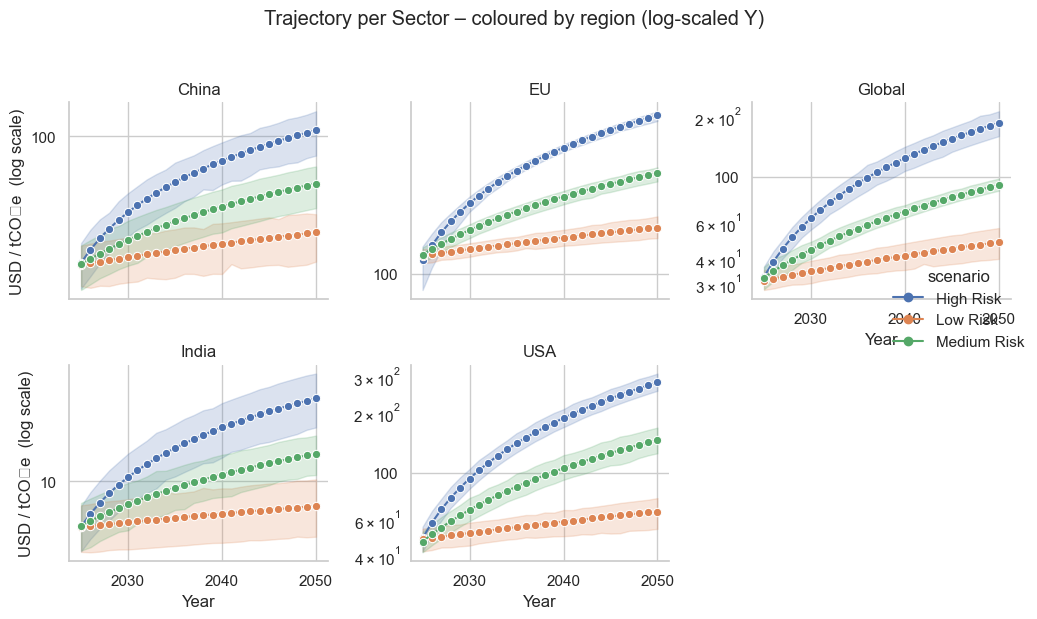

In [172]:
plot_df = carbon_prices_full.copy()
plot_df.loc[plot_df['carbon_price_usd_tco2e'] <= 0, 'carbon_price_usd_tco2e'] = np.nan

g = sns.relplot(
        data      = plot_df,
        x         = "year",
        y         = "carbon_price_usd_tco2e",
        hue       = "scenario",
        kind      = "line",
        marker    = "o",
        col       = "region",
        col_wrap  = 3,
        height    = 3,
        facet_kws = dict(sharey=False)
)

# put every facet on log-scale
for ax in g.axes.flatten():
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(
        plt.FuncFormatter(lambda v, p: f"{v:g}")
    )

g.set_titles("{col_name}")
g.fig.suptitle("Trajectory per Sector – coloured by region (log-scaled Y)", y=1.03)
g.set_axis_labels("Year", "USD / tCO₂e  (log scale)")
plt.tight_layout()
plt.show()

In [286]:
# ngf5_global_carbon_prices

/opt/anaconda3/envs/sp_work/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



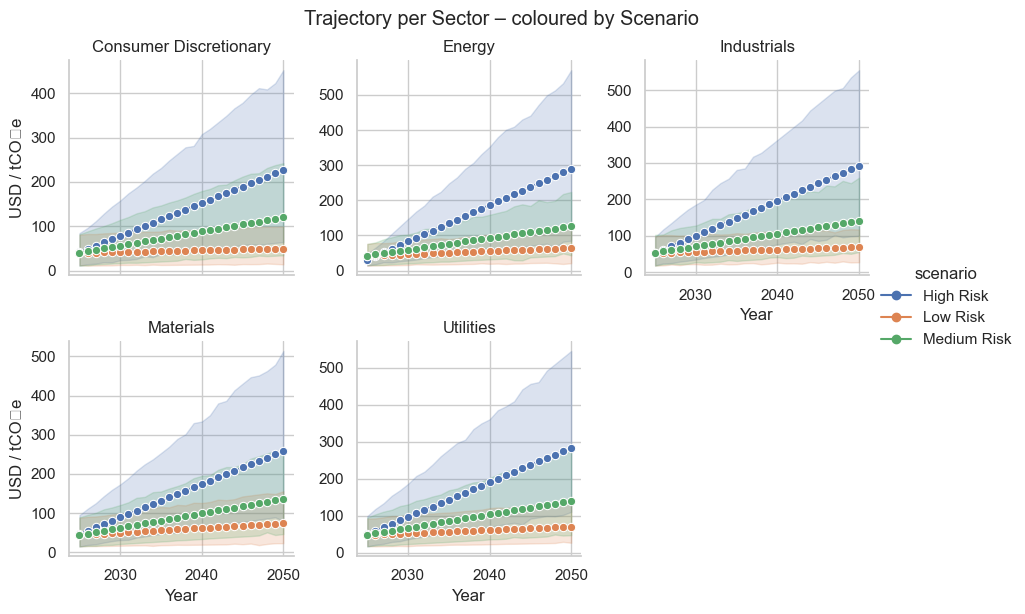

In [173]:
g = sns.relplot(
    data = carbon_prices_full,
    x="year", y="carbon_price_usd_tco2e",
    hue="scenario", kind="line", marker="o",
    col="sector", col_wrap=3, height=3, facet_kws={'sharey':False}
)
g.set_titles("{col_name}")
g.fig.suptitle("Trajectory per Sector – coloured by Scenario", y=1.02)
g.set_axis_labels("Year", "USD / tCO₂e")
plt.show()


Estimate Abatement

In [ ]:
# ================================================================
# Abatement-Cost Engine  –  v2 (front-loads CapEx, tracks spare)
# ================================================================


# ------------------------------------------------------------
# 0.  Helper to pick your emissions pathway
# ------------------------------------------------------------
def filter_paths(df, scenario='medium', interp='linear', verbose=True):
    """
    Return only the rows matching the chosen scenario & interpolation method.
    """
    out = df.query("scenario == @scenario and interpolation_method == @interp").copy()
    if out.empty:
        raise ValueError(
            f"No rows match scenario='{scenario}' & interpolation='{interp}'. "
            "Inspect available options:\n"
            "  df['scenario'].unique()\n  df['interpolation_method'].unique()"
        )
    if verbose:
        print(f"Filtered to {len(out):,} rows  (uids={out['uid'].nunique()})")
    return out


# ------------------------------------------------------------
# 1.  State-aware dispatcher
# ------------------------------------------------------------
def dispatch_with_capacity(tech_df, tonnes_needed, capacity_bank):
    """
    tech_df        : cost table for *one* (sector, region)
    tonnes_needed  : incremental abatement (tCO2e) required for this year
    capacity_bank  : dict {tech_name: spare_tonnes} carried year-to-year

    Returns
    -------
    packages      : list of dicts describing tonnes allocated + costs
    capacity_bank : updated spare-capacity ledger
    """
    packages = []

    # ---------- 1 ▸ use spare capacity first (OpEx only) ----------
    for tech, spare in list(capacity_bank.items()):
        if tonnes_needed <= 0:
            break
        take = min(spare, tonnes_needed)
        if take > 0:
            tech_row = tech_df.loc[tech_df['technology'] == tech].iloc[0]
            opex = tech_row['abatement_cost_usd_tco2e_year'] * take
            packages.append(dict(
                technology     = tech,
                new_build      = False,
                tonnes         = take,
                capex_usd      = 0.0,
                opex_usd_year  = opex,
            ))
            capacity_bank[tech] -= take
            tonnes_needed       -= take

    # ---------- 2 ▸ build new full-size packages as needed ----------
    tech_df = tech_df.sort_values('abatement_cost_usd_tco2e_year')   # cheapest first
    for _, t in tech_df.iterrows():
        if tonnes_needed <= 0:
            break

        tech_name   = t['technology']
        capacity    = t['abatement_capacity_tco2e_year']
        build_cost  = t['initial_investment_usd_million'] * 1e6      # M$ → $
        opex_rate   = t['abatement_cost_usd_tco2e_year']

        # build *one* unit
        take = min(capacity, tonnes_needed)

        packages.append(dict(
            technology     = tech_name,
            new_build      = True,
            tonnes         = take,
            capex_usd      = build_cost,                 # full CapEx up-front
            opex_usd_year  = opex_rate * take,
        ))

        # record spare capacity for future years
        leftover = capacity - take
        if leftover > 0:
            capacity_bank[tech_name] = capacity_bank.get(tech_name, 0) + leftover

        tonnes_needed -= take

    return packages, capacity_bank


# ------------------------------------------------------------
# 2.  Per-company engine
# ------------------------------------------------------------
def compute_company_abatement_costs(uid, df_paths, df_abatement, scope_map=None):
    """
    Return two dataframes:
        1) annual_df  – year-level CapEx, OpEx, cumulative values
        2) detail_df  – tech-level breakdown (what was built / used)
    """
    comp = df_paths[df_paths['uid'] == uid].copy()
    if comp.empty:
        raise ValueError(f'UID {uid} not found in emissions_paths.')

    # -------- meta data / tech catalogue (with fallbacks) --------
    sector = comp['gics_sector'].iat[0]
    region = comp['country'].iat[0]

    tech = df_abatement[(df_abatement['sector'] == sector) &
                        (df_abatement['region'] == region)]
    if tech.empty:
        tech = df_abatement[(df_abatement['sector'] == sector) &
                            (df_abatement['region'] == 'Global')]
    if tech.empty:
        tech = df_abatement[df_abatement['region'] == 'Global']
    if tech.empty:
        raise ValueError(f'No abatement technologies found for {sector}/{region}.')

    # -------- which scope counts toward the target? -------------
    if scope_map is None:
        scope_map = {
            'Scope 1': ['scope1_tonnes'],
            'Scope 2': ['scope2_tonnes'],
            'Scope 2 and other': ['scope1_tonnes', 'scope2_tonnes'],
            'Direct': ['scope1_tonnes', 'scope2_tonnes'],
        }
    tgt_type = comp['type_of_target'].iat[0]
    cols     = scope_map.get(tgt_type, ['scope1_tonnes', 'scope2_tonnes'])

    base_2025    = comp.loc[comp['year'] == 2025, cols].sum(axis=1).iat[0]
    prev_allowed = base_2025

    capacity_bank = {}        # spare capacity ledger
    records, detail_rows = [], []
    cum_capex = cum_opex = 0.0

    for yr in sorted(comp['year'].unique()):
        allowed = comp.loc[comp['year'] == yr, 'targeted_emissions'].iat[0]
        needed  = max(prev_allowed - allowed, 0)          # incremental tonnes

        pkgs, capacity_bank = dispatch_with_capacity(tech, needed, capacity_bank)
        capex = sum(p['capex_usd']      for p in pkgs)
        opex  = sum(p['opex_usd_year']  for p in pkgs)

        cum_capex += capex
        cum_opex  += opex

        records.append(dict(
            uid              = uid,
            year             = yr,
            abatement_tonnes = needed,
            capex_usd        = capex,
            opex_usd_year    = opex,
            cum_capex_usd    = cum_capex,
            cum_opex_usd     = cum_opex,
        ))

        for p in pkgs:
            detail_rows.append(dict(
                uid             = uid,
                year            = yr,
                technology      = p['technology'],
                new_build       = p['new_build'],
                tonnes          = p['tonnes'],
                capex_usd       = p['capex_usd'],
                opex_usd_year   = p['opex_usd_year'],
                spare_after_yr  = capacity_bank.get(p['technology'], 0),
            ))

        prev_allowed = allowed

    return pd.DataFrame(records), pd.DataFrame(detail_rows)


# ------------------------------------------------------------
# 3.  Portfolio runner
# ------------------------------------------------------------
def run_all_companies(df_paths, df_abatement):
    """
    Returns
    -------
    annual_full : yr-level costs for every company
    summary     : total CapEx / OpEx 2025-50 per company
    detail_full : tech-level rows (build / use each year)
    """
    annual_frames, detail_frames = [], []
    for uid in df_paths['uid'].unique():
        annual, detail = compute_company_abatement_costs(uid, df_paths, df_abatement)
        annual_frames.append(annual)
        detail_frames.append(detail)

    annual_full = pd.concat(annual_frames, ignore_index=True)
    detail_full = pd.concat(detail_frames, ignore_index=True)

    summary = (annual_full.groupby('uid')
                          .agg(total_capex_usd=('capex_usd', 'sum'),
                               total_opex_usd=('opex_usd_year', 'sum'),
                               total_abated_tonnes=('abatement_tonnes', 'sum'))
                          .reset_index())

    return annual_full, summary, detail_full




# keep only medium / linear pathway
paths_mid = filter_paths(emissions_paths, scenario='med', interp='linear')

# run the model
annual_df, summary_df, detail_df = run_all_companies(paths_mid, df_abatement)

print("\n=== Company-level totals ===")
print(summary_df.head())

print("\n=== First few tech-level rows ===")
print(detail_df.head())

#export csv
annual_df.to_csv("annual_abatement_costs.csv", index=False)

#export csv
summary_df.to_csv("abatement_summary.csv", index=False)
#export csv
detail_df.to_csv("abatement_detail.csv", index=False)

Filtered to 1,274 rows  (uids=48)

=== Company-level totals ===
    uid  total_capex_usd  total_opex_usd  total_abated_tonnes
0  C001     4.418190e+09    1.964819e+07             585290.0
1  C002     8.205210e+09    3.670457e+07            1093374.0
2  C003     2.249050e+10    1.920049e+08            6939120.0
3  C004     4.827500e+09    4.218650e+07            3222320.0
4  C005     5.975138e+10    1.110492e+09                  0.0

=== First few tech-level rows ===
    uid  year  technology  new_build   tonnes    capex_usd  opex_usd_year  \
0  C001  2026  Wind Power       True  23412.0  631170000.0      785940.84   
1  C001  2027  Wind Power      False  23411.0          0.0      785907.27   
2  C001  2028  Wind Power      False  23412.0          0.0      785940.84   
3  C001  2029  Wind Power      False  19952.0          0.0      669788.64   
4  C001  2029  Wind Power       True   3459.0  631170000.0      116118.63   

   spare_after_yr  
0         66775.0  
1         43364.0  
2     

In [299]:
# emissions_paths.head()

In [211]:
def filter_paths(df, scenario='med', interp='linear'):
    return df.query("scenario == @scenario and interpolation_method == @interp").copy()

all_yearly, company_totals = run_all_companies(
    filter_paths(emissions_paths, 'med', 'linear'),
    df_abatement
)


In [292]:
all_yearly.head()

,uid,year,abatement_tonnes,capex_usd,opex_usd_year,cum_capex_usd,cum_opex_usd
0,C001,2025,0.0,0.000000e+00,0.00,0.000000e+00,0.00
1,C001,2026,23412.0,1.638479e+08,785940.84,1.638479e+08,785940.84
2,C001,2027,23411.0,1.638409e+08,785907.27,3.276888e+08,1571848.11
3,C001,2028,23412.0,1.638479e+08,785940.84,4.915368e+08,2357788.95
4,C001,2029,23411.0,1.638409e+08,785907.27,6.553777e+08,3143696.22


In [293]:
company_totals.head()

,uid,total_capex_usd,total_opex_usd,total_abated_tonnes
0,C001,4.096128e+09,1.964819e+07,585290.0
1,C002,7.651933e+09,3.670457e+07,1093374.0
2,C003,2.249050e+10,1.920049e+08,6939120.0
3,C004,4.827500e+09,4.218650e+07,3222320.0
4,C005,5.975138e+10,1.110492e+09,0.0


In [ ]:


def build_tradeoff_table(annual_df, emissions_paths, carbon_prices_full):
    # ── 1. Merge emissions + abatement ────────────────────────────────
    emis = (emissions_paths
            .assign(e_total=lambda d: d['scope1_tonnes'] + d['scope2_tonnes'])
            .loc[:, ['uid', 'year', 'gics_sector', 'country', 'e_total']])

    abat = (annual_df
            .loc[:, ['uid', 'year',
                     'abatement_tonnes', 'capex_usd', 'opex_usd_year']]
            .sort_values(['uid', 'year'])
            .assign(capex_cum=lambda d: d.groupby('uid')['capex_usd'].cumsum(),
                    opex_cum =lambda d: d.groupby('uid')['opex_usd_year'].cumsum()))

    base = emis.merge(abat, on=['uid', 'year'], how='left').fillna(0)

    # ── 2. Cross-join every scenario (Low / Medium / High) ────────────
    scenarios = carbon_prices_full['scenario'].unique()
    base = (base.assign(key=1)
                 .merge(pd.DataFrame({'scenario': scenarios, 'key': 1}),
                        on='key').drop('key', axis=1))

    # ── 3. Attach carbon prices with Global fallback ──────────────────
    price_cols = ['sector', 'region', 'scenario',
                  'year', 'carbon_price_usd_tco2e']
    prices = carbon_prices_full[price_cols]

    df = base.merge(
        prices,
        left_on =['gics_sector','country','scenario','year'],
        right_on=['sector'     ,'region' ,'scenario','year'],
        how='left')

    miss = df['carbon_price_usd_tco2e'].isna()
    if miss.any():
        global_prices = prices[prices['region'] == 'Global']
        df.loc[miss, 'carbon_price_usd_tco2e'] = (
            df[miss]
            .merge(global_prices,
                   on=['sector','scenario','year'],
                   how='left')['carbon_price_usd_tco2e_y']
        )

    # ── 4. Compute cost metrics ───────────────────────────────────────
    df['carbon_cost_without_usd'] = df['e_total'] * df['carbon_price_usd_tco2e']
    df['carbon_cost_with_usd']    = (
        (df['e_total'] - df['abatement_tonnes']) *
        df['carbon_price_usd_tco2e']
    )
    df['total_cost_with_abatement_usd'] = (
        df['capex_cum'] + df['opex_cum'] + df['carbon_cost_with_usd']
    )
    df['net_savings_usd'] = (
        df['carbon_cost_without_usd'] - df['total_cost_with_abatement_usd']
    )

    return df[['uid','scenario','year',
               'carbon_cost_without_usd',
               'total_cost_with_abatement_usd',
               'net_savings_usd']]

tradeoffs = build_tradeoff_table(annual_df, emissions_paths, carbon_prices_full)

# ── Export the tradeoff table ───────────────────────────────────────
tradeoffs.to_csv("tradeoff_table.csv", index=False)


In [298]:
# tradeoffs.head()